# Imports

In [1]:
import numpy as np
import nltk.corpus
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import lightgbm as lgb
import pickle
import joblib

# Reading the database

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# No. of positive tweets
data[data['label'] == 0].count()

id       29720
label    29720
tweet    29720
dtype: int64

In [7]:
# No of negative tweets
data[data['label'] == 1].count()

id       2242
label    2242
tweet    2242
dtype: int64

# Preprocessing the data

In [8]:
data.dropna(inplace=True)

##### Removing the user tags

In [9]:
def clean_tags(tweet):
    tags = re.findall("@[\w]*", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [10]:
data['cleaned_tweets'] = data['tweet'].apply(clean_tags)
data.head()

,id,label,tweet,cleaned_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


##### Removing the punctuations

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def clean_punctuations(tweet):
    punctuations = '[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    for i in tweet:
        if i in punctuations:
            re.sub(i, "", tweet)
    return tweet
# string.punctuation

In [13]:
# print(type(string.punctuation))
data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")
data['cleaned_tweets'].head(-5)
# data['cleaned_tweets'].iloc[31957]

/tmp/ipykernel_132848/1869601397.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")


0          when a father is dysfunctional and is so sel...
1          thanks for #lyft credit i can t use cause th...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide  society now    #motivation
                               ...                        
31952                             you went too far with   
31953    good morning #instagram #shower #water #berlin...
31954    #holiday   bull up  you will dominate your bul...
31955    less than   weeks                           #i...
31956    off fishing tomorrow  carnt wait first time in...
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing words less than a given size

In [14]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : ["".join(word) for word in x.split() if len(word) > 4])

In [15]:
data['cleaned_tweets']

0        [father, dysfunctional, selfish, drags, dysfun...
1        [thanks, #lyft, credit, cause, offer, wheelcha...
2                                        [bihday, majesty]
3                                                 [#model]
4                       [factsguide, society, #motivation]
                               ...                        
31957                                              [youuu]
31958    [turner, airwaves, trying, herself, mantle, ge...
31959                  [listening, songs, monday, morning]
31960     [#sikh, #temple, vandalised, #calgary, condemns]
31961                                      [thank, follow]
Name: cleaned_tweets, Length: 31962, dtype: object

In [16]:
def joinWords(tweet):
    ans = ""
    for word in tweet:
        ans = " ".join(tweet)
    return ans

In [17]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [18]:
data['cleaned_tweets']

0           father dysfunctional selfish drags dysfunction
1        thanks #lyft credit cause offer wheelchair #di...
2                                           bihday majesty
3                                                   #model
4                           factsguide society #motivation
                               ...                        
31957                                                youuu
31958    turner airwaves trying herself mantle genuine ...
31959                       listening songs monday morning
31960           #sikh #temple vandalised #calgary condemns
31961                                         thank follow
Name: cleaned_tweets, Length: 31962, dtype: object

###### Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer

In [20]:
lemmer = WordNetLemmatizer()

In [21]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : [lemmer.lemmatize(word) for word in x.split()])
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [22]:
data['cleaned_tweets'].head(-5)

0            father dysfunctional selfish drag dysfunction
1        thanks #lyft credit cause offer wheelchair #di...
2                                           bihday majesty
3                                                   #model
4                           factsguide society #motivation
                               ...                        
31952                                                     
31953    morning #instagram #shower #water #berlin #ber...
31954                    #holiday dominate direct whatever
31955       week #ibiza#bringiton#mallorca#holidays#summer
31956                    fishing tomorrow carnt first year
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing Hashtags

In [23]:
def removeHashtags(tweet):
    tags = re.findall("#", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [24]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(removeHashtags)
data['cleaned_tweets'].head(-5)
# count = 0
# for i in data['cleaned_tweets'].iloc[31953].split():
#     count += 1
# print(count)

0            father dysfunctional selfish drag dysfunction
1        thanks lyft credit cause offer wheelchair disa...
2                                           bihday majesty
3                                                    model
4                            factsguide society motivation
                               ...                        
31952                                                     
31953    morning instagram shower water berlin berlinci...
31954                     holiday dominate direct whatever
31955            week ibizabringitonmallorcaholidayssummer
31956                    fishing tomorrow carnt first year
Name: cleaned_tweets, Length: 31957, dtype: object

# Exploratory Data Analysis

##### Calculating Length of each tweet

In [25]:
data['length'] = data['cleaned_tweets'].apply(lambda x : len(x))
data.head(-5)

,id,label,tweet,cleaned_tweets,length
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag dysfunction,45
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cause offer wheelchair disa...,64
2,3,0,bihday your majesty,bihday majesty,14
3,4,0,#model i love u take with u all the time in ...,model,5
4,5,0,factsguide: society now #motivation,factsguide society motivation,29
...,...,...,...,...,...
31952,31953,0,@user you went too far with @user,,0
31953,31954,0,good morning #instagram #shower #water #berlin...,morning instagram shower water berlin berlinci...,75
31954,31955,0,#holiday bull up: you will dominate your bul...,holiday dominate direct whatever,32
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...,week ibizabringitonmallorcaholidayssummer,41


##### Checking to see if length dictates the sentiment of tweet

<Axes: xlabel='label', ylabel='length'>

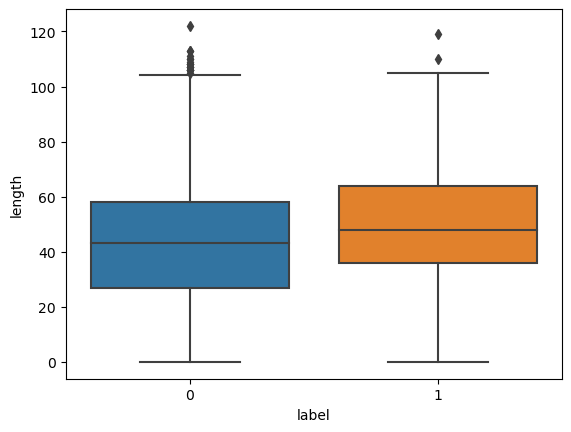

In [26]:
sns.boxplot(data = data, x = 'label', y = 'length')

##### Count of positive and negative tweets

<Axes: xlabel='label', ylabel='count'>

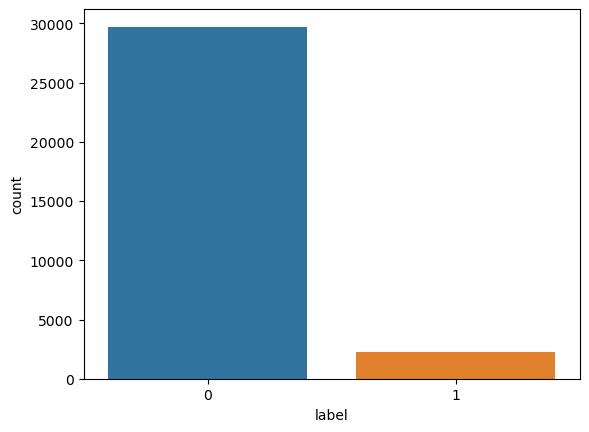

In [27]:
sns.countplot(data = data, x = 'label')

# Creating and training the model

##### Creating a bag of words

In [28]:
# def joinWords(tweet):
#     ans = ""
#     for word in tweet:
#         ans = " ".join(tweet)
#     return ans

In [29]:
allWords = ""
for tweet in data['cleaned_tweets']:
    allWords = allWords + tweet + " "

allWords = allWords.rstrip()
allWords

'father dysfunctional selfish drag dysfunction thanks lyft credit cause offer wheelchair disapointed getthanked bihday majesty model factsguide society motivation talking before leave chaos dispute there allshowandnogo camping tomorrow danny school exam think about school exams hate imagine actorslife revolutionschool girl allin cavs champions cleveland clevelandcavaliers welcome ireland consumer price index climbed previous blog silver gold forex selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking values love daddy today gettingfed call michigan middle school build chant tcot comment australia opkillingbay seashepherd helpcovedolphins thecove helpcovedolphins junior angry junior yugyoem thankful having paner thankful positive retweet agree friday smile around cookies people essential chemical euro people blaming conceded rooney knowing there little badday coneofshame cats pissed funny laughs product happy wine weekend drink lumpy prove lum

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vect = CountVectorizer(stop_words = 'english')

In [32]:
count_vect = count_vect.fit_transform(data['cleaned_tweets'])

In [33]:
count_vect = count_vect.astype(np.float64)

##### Splitting the data

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [35]:
print(count_vect)

  (0, 8168)	1.0
  (0, 8442)	1.0
  (0, 8443)	1.0
  (0, 9727)	1.0
  (0, 25349)	1.0
  (1, 4669)	1.0
  (1, 6453)	1.0
  (1, 7691)	1.0
  (1, 11355)	1.0
  (1, 17286)	1.0
  (1, 20523)	1.0
  (1, 28644)	1.0
  (1, 31540)	1.0
  (2, 2893)	1.0
  (2, 17461)	1.0
  (3, 18599)	1.0
  (4, 9519)	1.0
  (4, 18876)	1.0
  (4, 26509)	1.0
  (5, 729)	1.0
  (5, 4859)	1.0
  (5, 7802)	1.0
  (5, 16168)	1.0
  (5, 28225)	1.0
  (6, 4333)	1.0
  :	:
  (31956, 4545)	1.0
  (31956, 10182)	1.0
  (31956, 29334)	1.0
  (31956, 32307)	1.0
  (31957, 32506)	1.0
  (31958, 518)	1.0
  (31958, 5129)	1.0
  (31958, 11287)	1.0
  (31958, 14034)	1.0
  (31958, 17659)	1.0
  (31958, 25591)	1.0
  (31958, 25749)	1.0
  (31958, 29839)	1.0
  (31958, 29922)	1.0
  (31959, 16613)	1.0
  (31959, 18683)	1.0
  (31959, 18818)	1.0
  (31959, 26625)	1.0
  (31960, 4255)	1.0
  (31960, 5892)	1.0
  (31960, 25956)	1.0
  (31960, 28516)	1.0
  (31960, 30527)	1.0
  (31961, 10420)	1.0
  (31961, 28633)	1.0


In [36]:
x = count_vect;
y = data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

##### Creating a model (LightGBM)

In [37]:
# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

##### Creating a model (Logistic Regression)

In [38]:
model2 = LogisticRegression(random_state = 42)
model2.fit(x_train, y_train)

LogisticRegression(random_state=42)

##### Creating a model (Random Forrest Classifier)

In [39]:
# from sklearn.ensemble import RandomForestClassifier

In [40]:
# model3 = RandomForestClassifier(random_state = 42, verbose = 2, n_estimators=10)

In [41]:
# model3.fit(x_train, y_train)

##### Creating a model (Decision Tree)

In [42]:
# from sklearn.tree import DecisionTreeClassifier

In [43]:
# model4 = DecisionTreeClassifier(random_state = 42)

In [44]:
# model4.fit(x_train, y_train)

# Making Predictions

##### Predictions from LightGBM classifier

In [45]:
# pred = model.predict(x_test)

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
# print(accuracy_score(pred, y_test))

##### Predictions from Logistic Regression model

In [48]:
pred2 = model2.predict(x_test)

In [49]:
print(accuracy_score(pred2, y_test))

0.9545312337052874


##### Predictions from RandomForrest classifier

In [50]:
# pred3 = model3.predict(x_test)

In [51]:
# print(accuracy_score(pred3, y_test))

##### Predictions from Decision Tree classifier

In [52]:
# pred4 = model4.predict(x_test)

In [53]:
# print(accuracy_score(pred4, y_test))

# Saving the best algorithm

In [54]:
from joblib import Parallel, delayed
joblib.dump(model2, "model.pkl")

['model.pkl']

# Testing the model

In [55]:
tweet = "#awesome Newbie!!! is a good boy."

In [56]:
tweet = clean_tags(tweet)

In [57]:
tweet = clean_punctuations(tweet)
tweet

'#awesome Newbie!!! is a good boy.'

In [58]:
tweet = removeHashtags(tweet)
tweet

'awesome Newbie!!! is a good boy.'

In [62]:
countv = CountVectorizer()

In [65]:
c = countv.fit_transform(tweet)

ValueError: Iterable over raw text documents expected, string object received.

In [60]:
prediction = model2.predict(tweet)

ValueError: Expected 2D array, got scalar array instead:
array=awesome Newbie!!! is a good boy..
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.